[Reference](https://arshren.medium.com/unlocking-the-secrets-of-actor-critic-reinforcement-learning-a-beginners-guide-3c5953b13551)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[array([0.91404057], dtype=float32), array([0.84703153], dtype=float32), array([0.6343682], dtype=float32), array([0.5749416], dtype=float32), array([0.63884467], dtype=float32), array([0.536982], dtype=float32), array([0.45524666], dtype=float32), array([0.629002], dtype=float32), array([0.5277438], dtype=float32), array([0.3578375], dtype=float32), array([0.37617245], dtype=float32), array([0.38194102], dtype=float32), array([0.16358313], dtype=float32), array([0.35614407], dtype=float32), array([0.24352519], dtype=float32), array([0.26502872], dtype=float32), array([0.18860486], dtype=float32), array([0.11952897], dtype=float32), array([0.15232398], dtype=float32), array([0.09177656], dtype=float32), array([0.13639574], dtype=float32), array([-0.03724138], dtype=float32), array([0.29504597], dtype=float32), array([-0.05495174], dtype=float32), array([-0.032899], dtype=float32), array([0.31353834], dtype=float32), array([-0.0622535], dtype=float32), array([0.10922889], dtype=float32)

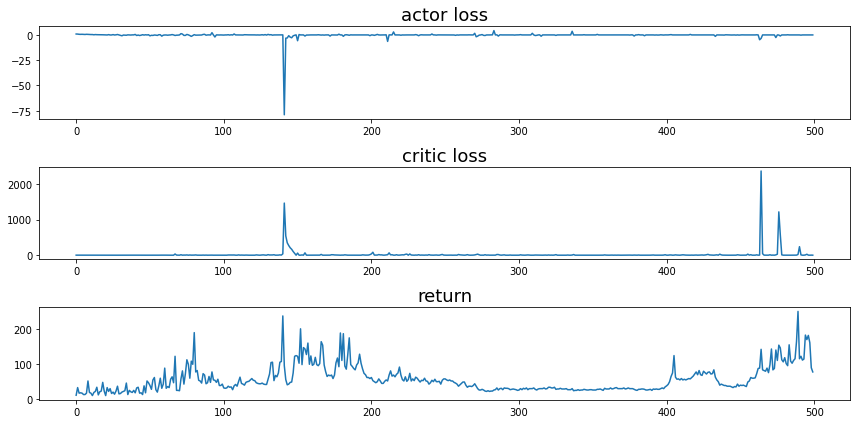

In [32]:
#Import required Libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Create the Actor Network
'''
Defines a class "Actor" that implements a deep neural network model 
a simple feedforward neural network with 3 linear layers and ReLU activation functions
outputs the probability of taking a specific action given the current state.
'''
class Actor(nn.Module):

    def __init__(self, state_dim,  action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
      
#Deines the Critic Network
'''
The critic network estimates the expected return or value of a state or a state-action pair
a simple feedforward neural network with 3 linear layers and ReLU activation functions
outputs a scalar value, representing the estimated value of a state or a state-action pair
'''
class Critic(nn.Module):

  def __init__(self, state_dim):
      super(Critic, self).__init__()
      self.fc1 = nn.Linear(state_dim, 64)
      self.fc2 = nn.Linear(64, 32)
      self.fc3 = nn.Linear(32, 1)

  def forward(self, x):
      out = F.relu(self.fc1(x))
      out = F.relu(self.fc2(out))
      out = self.fc3(out)
      return out
# Create the CartPole environemnt
env = gym.make("CartPole-v1")
env.seed(0)
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

#create Actor and Critic
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
# setting the optimizer and learning rate
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
episode_rewards = []
episode_num=500
stats={'actor loss':[], 'critic loss':[], 'return':[]}

'''
each episode, the code resets the environment using the "env.reset()" method, 
repeatedly takes actions in the environment and 
updates the parameters of the actor and critic networks until the episode is done. 
The "done" flag is set to True when the episode is terminated.
'''
for i in range(episode_num):
    done = False
    total_reward = 0
    state = env.reset()
    env.seed(0)

    while not done:
        '''
        The actor network outputs the probability of taking each possible action, 
        which are used to sample an action using the Categorical distribution 
        '''
        probs = actor(torch.from_numpy(state).float())
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        #performs the action and receives the next state, reward, and "done" flag from the environment
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        #The reward and the estimated value of the next state are used to calculate the advantage, 
        #which is the expected return of taking the action minus the estimated value of the current state.
        advantage = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float()) - critic(torch.from_numpy(state).float())                                   
                                             
        total_reward += reward
        state = next_state
       
        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()
        #actor loss=negative of the log probability of the action taken, multiplied by the advantage
        actor_loss = -dist.log_prob(action)*advantage.detach()
        
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
    stats['actor loss'].append(actor_loss.detach().numpy())
    stats['critic loss'].append(critic_loss.detach().numpy())
    stats['return'].append(total_reward)
            
    episode_rewards.append(total_reward)

def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        print(vals)
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

plot_stats(stats)